***
<center><h1>Face Rhythm</h1></center>

***

<table><tr>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723283221-5Z5038AT7Y6KCOM2PIU4/Screenshot+from+2021-03-02+17-05-12.png?content-type=image%2Fpng" style="height: 200px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723856628-J89PYYSF7K7JATE2KMF9/Screenshot+from+2021-03-02+17-23-46.png?format=300w&content-type=image%2Fpng" style="height: 200px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723931026-OORV0RAPZNWV3R8TBOXB/Screenshot+from+2021-03-02+17-25-11.png?format=300w&content-type=image%2Fpng" style="height: 200px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614724055033-O3GBEF1D9MULFZKI2IUJ/Screenshot+from+2021-03-02+17-27-10.png?format=300w&content-type=image%2Fpng" style="height: 200px"> </td>
<td> <img src="https://images.squarespace-cdn.com/content/5688a31305f8e23aa2893502/1614723378405-WXN74ZTT1KYZUQGDM07X/face_rhythm_banner2.png?format=1000w&content-type=image%2Fpng" style="height: 200px"> </td>
</tr></table>

***

##### Notebook Shortcuts
- **[Notebook Setup](#Notebook-Setup)**: Prepare all the necessary config files and folders
- **[Set ROI](#Set-ROI)**: Set the ROI for the analysis
- **[Run Optic Flow](#Run-Optic-Flow)**: Run the optic flow analysis
- **[Clean Optic Flow](#Clean-Optic-Flow)**: Optic flow post-processing
- **[Convolutional Dimensionality Reduction](#Convolutional-Dimensionality-Reduction)**: Convolutional Dimensionality Reduction
- **[Analysis](#Analysis)**: Decompose and Analyze the optic flow data in many ways
- **[Comparisons](#Comparisons)**: Compare Face Rhythm to some peer algorithms

***

# Tips on running this notebook:
In theory it would be nice if you could just enter the path of the video(s) and just let it run all the way through. In practice, there are a few hoops to jump through
- Run the Notebook Setup Block (two blocks below this one). This should pretty much always be done, even if you are loading precomputed file from disk instead of calculating them. This step loads in some useful meta data used throughout.
- Even if you are restarting at a specific point in your analysis, run your Setup Block then head down to your current analysis step cell 

***
<center><h1>Notebook Setup</h1></center>

***

### Creates config and locates videos

**Crucially, always run this first cell every time you run this notebook.**

Also, generally make sure to read through the config parameters before running.

The Project path is the path to a folder (existing or not) where we will store our derived files. I recommend creating a project folder and then copying this notebook into that folder.
The Video path is the path to a folder containing videos. 
The run name will determine the name of the config. You might create multiple configs if you want to re-run the same data with slightly different parameters

Previous face rhythm users might be familiar with the 'sessions' structure. Some users will want to run multiple sessions through Face Rhythm at the same time. If that's you, then read the docs to see what parameters to change:
https://face-rhythm.readthedocs.io/

If you did everything according to the readme, you should see that the video_path currently points to a folder containing one sample video in the testing folder. Give this a try!

In [2]:
# ALWAYS RUN THIS CELL
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
import face_rhythm as fr

In [4]:
from pprint import pprint
from pathlib import Path

import cv2

In [5]:
import numpy as np
import torch
import matplotlib.pyplot

In [6]:
fr.helpers.get_system_versions(verbose=True);

Operating System: Linux: 5.15.0-53-generic, #59~20.04.1-Ubuntu SMP Thu Oct 20 15:10:22 UTC 2022, x86_64, node: rich-L-CLASS
Conda Environment: FR
Python Version: 3.9.13
GCC Version: 9.4.0
PyTorch Version: 1.12.0+cu113
Numpy Version: 1.21.6
OpenCV Version: 4.6.0
face-rhythm Version: 0.1.0


# Project Directory Organization
------------

    Project Directory
    ├── config.yaml           <- Configuration parameters to run each module in the pipeline. Dictionary.
    ├── run_info.yaml         <- Output information from each module. Dictionary.
    │
    ├── run_data              <- Output data from each module.
    │   ├── point_tracking.h5 <- Output data from optic flow module.
    │   ├── spectral.h5       <- Output data from spectral decomposition module.
    │   └── decomposition.h5  <- Output data from PCA/TCA modules.
    │   
    └── visualizations        <- Output visualizations.
        ├── example_plot.png  <- Example plot.
        └── example_video.mp4 <- Example video.


In [7]:
directory_project = '/media/rich/bigSSD/analysis_data/demo_faceRhythm_svoboda/fr_run_20221013_new/'
directory_videos  = '/media/rich/bigSSD/other lab data/Svoboda_lab/BCI34_2022-07-19/side/2022-07-19_13-34-06'

filename_strMatch = 'trial_.*mp4'  ## You can use regular expressions to search and match more complex strings

In [113]:
path_config, path_run_info, directory_project = fr.project.prepare_project(
    directory_project=directory_project,
    overwrite_config=False,  ## WARNING! CHECK THIS.
    verbose=2,
)

Initializing cv2.imshow
FR: Found config.yaml file at /media/rich/bigSSD/analysis_data/demo_faceRhythm_svoboda/fr_run_20221013_new/config.yaml


In [54]:
paths_videos = fr.helpers.find_paths(
    dir_outer=directory_videos,
    reMatch=filename_strMatch,  ## string to use to search for files in directory. Uses regular expressions!
    depth=0,  ## how many folders deep to search
)

pprint(paths_videos, width=1000)

['/media/rich/bigSSD/other lab data/Svoboda_lab/BCI34_2022-07-19/side/2022-07-19_13-34-06/trial_00000__2022-07-19_13-34-07.mp4',
 '/media/rich/bigSSD/other lab data/Svoboda_lab/BCI34_2022-07-19/side/2022-07-19_13-34-06/trial_00001__2022-07-19_13-34-51.mp4',
 '/media/rich/bigSSD/other lab data/Svoboda_lab/BCI34_2022-07-19/side/2022-07-19_13-34-06/trial_00002__2022-07-19_13-35-02.mp4',
 '/media/rich/bigSSD/other lab data/Svoboda_lab/BCI34_2022-07-19/side/2022-07-19_13-34-06/trial_00003__2022-07-19_13-35-14.mp4',
 '/media/rich/bigSSD/other lab data/Svoboda_lab/BCI34_2022-07-19/side/2022-07-19_13-34-06/trial_00004__2022-07-19_13-35-24.mp4',
 '/media/rich/bigSSD/other lab data/Svoboda_lab/BCI34_2022-07-19/side/2022-07-19_13-34-06/trial_00005__2022-07-19_13-35-36.mp4',
 '/media/rich/bigSSD/other lab data/Svoboda_lab/BCI34_2022-07-19/side/2022-07-19_13-34-06/trial_00006__2022-07-19_13-35-49.mp4',
 '/media/rich/bigSSD/other lab data/Svoboda_lab/BCI34_2022-07-19/side/2022-07-19_13-34-06/trial_0

In [55]:
videos = fr.helpers.BufferedVideoReader(
#     video_readers=data.videos, 
    paths_videos=paths_videos,
    buffer_size=1000, 
    prefetch=1, 
    posthold=1,
    method_getitem='by_video',
    verbose=1,
)

In [81]:
data = fr.data_importing.Dataset_videos(
    bufferedVideoReader=videos,
#     paths_videos=paths_videos,
    contiguous=False,
    frame_rate_clamp=240,
    verbose=2,
)

In [82]:
# data.save_config(path_config=path_config, overwrite=True, verbose=1)
# data.save_run_info(path_config=path_config, overwrite=True, verbose=1)
# data.save_run_data(path_config=path_config, overwrite=True, verbose=1)

In [83]:
# %matplotlib notebook
rois = fr.rois.ROIs(
#     select_mode='gui',
#     exampleImage=data[0][0],
    select_mode='file',
    file_path=str(Path(directory_project) / 'analysis_files' / 'ROIs.h5'),
    verbose=2
)

In [84]:
# rois.save_config(path_config=path_config, overwrite=True, verbose=1)
# rois.save_run_info(path_config=path_config, overwrite=True, verbose=1)
# rois.save_run_data(path_config=path_config, overwrite=True, verbose=1)

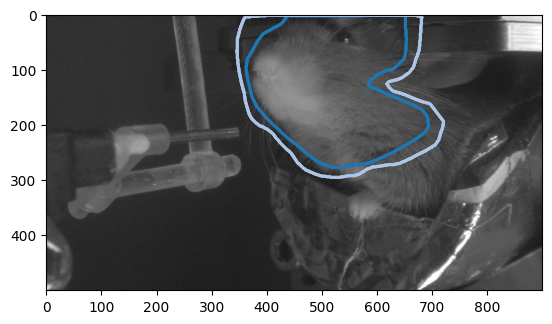

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

In [85]:
rois.plot_masks(data[0][0])

In [98]:
pt = fr.point_tracking.PointTracker(
    buffered_video_reader=videos[:5],
#     buffered_video_reader=videos,
    rois_points=[rois[0]],
    rois_masks=[rois[1]],
    contiguous=False,
    params_optical_flow={
        "method": "lucas_kanade",
        "point_spacing": 6,
        "mesh_rigidity": 0.01,
        "mesh_n_neighbors": 15,
#         "relaxation": 0.0010,
        "kwargs_method": {
            "winSize": [22,22],
            "maxLevel": 2,
            "criteria": [cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 2, 0.03],
        },        
    },
    visualize_video=False,
    params_visualization={
                'alpha':0.2,
                'point_sizes':2,
                'writer_cv2':None,
    },
    params_outlier_handling = {
        'threshold_displacement': 80,  ## Maximum displacement between frames, in pixels.
        'framesHalted_before': 30,  ## Number of frames to halt tracking before a violation.
        'framesHalted_after': 30,  ## Number of frames to halt tracking after a violation.
    },

    verbose=2,
)

FR: Setting parameters for optical flow
FR WARNING: Following parameters for optical flow were not specified and will be set to default values: {'relaxation': 0.5}
FR: Making points to track
FR: 1817 points will be tracked
FR: Collapsing mask ROI images into single mask
FR: Initializing mesh distances


In [100]:
pt.track_points()

FR: Setting initial frame_prev
FR: Iterating point tracking through videos


video #:   0%|                                            | 0/5 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [230]:
pt.save_config(path_config=path_config, overwrite=True, verbose=1)
pt.save_run_info(path_config=path_config, overwrite=True, verbose=1)
pt.save_run_data(path_config=path_config, overwrite=True, use_compression=True, verbose=1)

FR Warning: Overwriting field. 'PointTracker' already in config.yaml.
FR Warning: Overwriting field. 'PointTracker' is already a field in the run_info.yaml dictionary.
FR Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/demo_faceRhythm_svoboda/fr_run_20221013_new/analysis_files/PointTracker.h5 already exists.


In [211]:
pt.cleanup()

FR: Deleting all attributes


In [9]:
pt_data = fr.h5_handling.simple_load(str(Path(directory_project) / 'analysis_files' / 'PointTracker.h5'))
pt_data.unlazy()

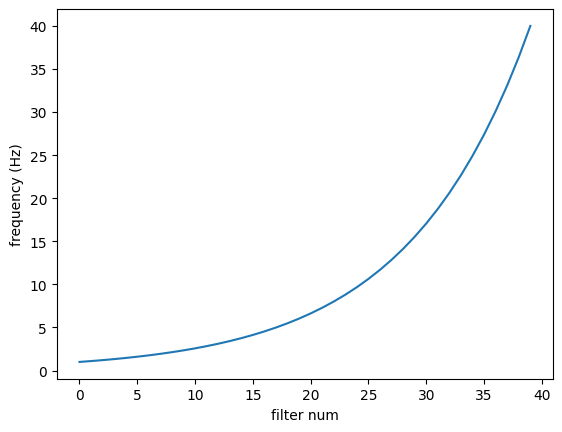

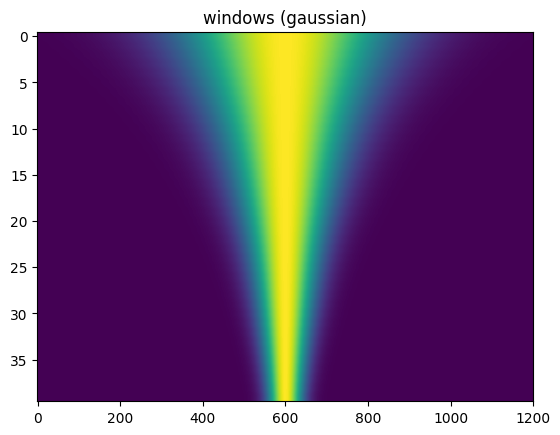

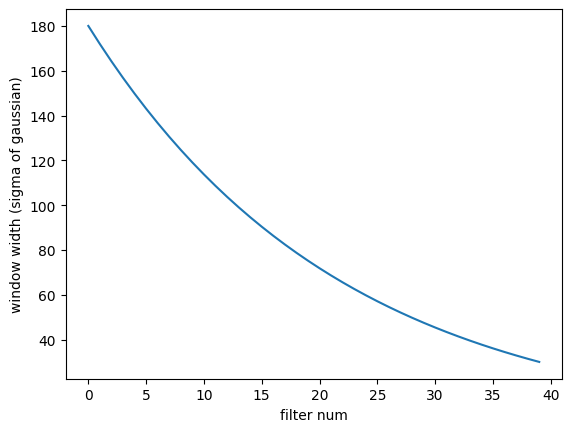

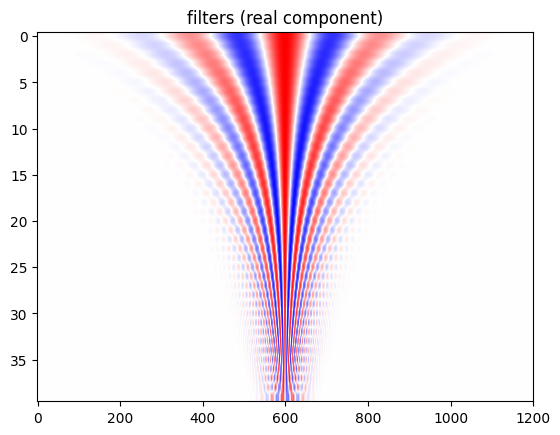

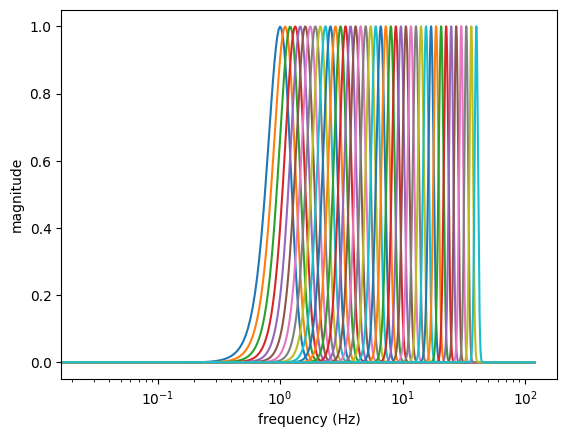

In [50]:
spec = fr.spectral_analysis.VQT_Analyzer(
    params_VQT = {
        'Fs_sample': 240, 
        'Q_lowF': 3, 
        'Q_highF': 20, 
        'F_min': 1, 
        'F_max': 40, 
        'n_freq_bins': 40, 
        'win_size': 1201, 
        'plot_pref': True, 
        'downsample_factor': 20, 
        'DEVICE_compute': 'cuda:0', 
        'batch_size': 1000,
        'return_complex': False, 
        'progressBar': True
    },
    normalization_factor=1.0,
    spectrogram_exponent=1.0,
    verbose = 2,
)

In [51]:
spec.VQT.args

{'Fs_sample': 1000,
 'Q_lowF': 3,
 'Q_highF': 20,
 'F_min': 10,
 'F_max': 400,
 'n_freq_bins': 55,
 'win_size': 501,
 'downsample_factor': 4,
 'DEVICE_compute': 'cpu',
 'DEVICE_return': 'cpu',
 'batch_size': 1000,
 'return_complex': False,
 'filters': None,
 'plot_pref': False,
 'progressBar': True}

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 212.39it/s]


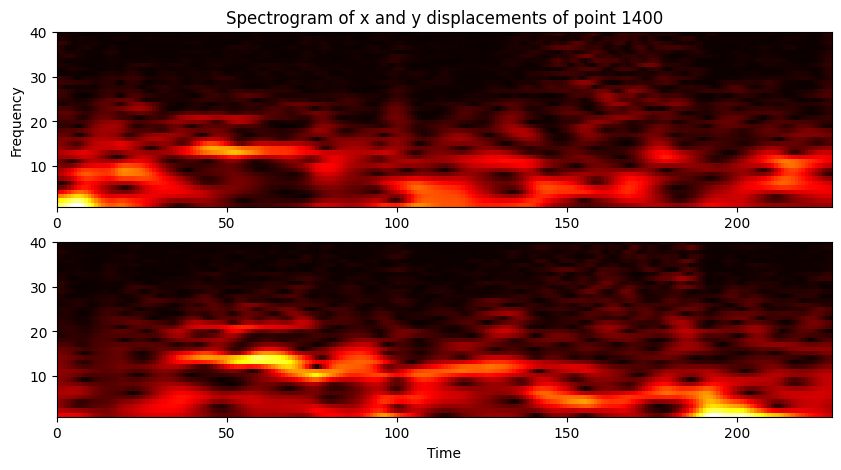

In [41]:
test = spec.test_transform(
    points_tracked=pt_data['points_tracked'],
    point_positions=pt_data['point_positions'],
    idx_point=1400,
    name_points='0',
    plot=True,
);

In [43]:
spec.transform(
    points_tracked=pt_data['points_tracked'],
    point_positions=pt_data['point_positions'],
)

Preparing traces. Reshaping and subtracting offsets...


Computing spectrograms:   0%|                             | 0/5 [00:00<?, ?it/s]

  0%|                                                     | 0/4 [00:00<?, ?it/s]

 25%|███████████▎                                 | 1/4 [00:00<00:00,  9.17it/s]

 50%|██████████████████████▌                      | 2/4 [00:00<00:00,  9.43it/s]

Computing spectrograms:  20%|████▏                | 1/5 [00:00<00:02,  1.87it/s]

  0%|                                                     | 0/4 [00:00<?, ?it/s]

 50%|██████████████████████▌                      | 2/4 [00:00<00:00, 11.34it/s]

Computing spectrograms:  40%|████████▍            | 2/5 [00:01<00:01,  2.01it/s]

  0%|                                                     | 0/4 [00:00<?, ?it/s]

 25%|███████████▎                                 | 1/4 [00:00<00:00,  9.47it/s]

 50%|██████████████████████▌                      | 2/4 [00:00<00:00,  9.76it/s]

Computing spectrograms:  60%|████████████▌        | 3/5 [00:01<00:01,  1.97it/s]

  0%|           

In [ ]:
spec.VQT.

In [13]:
spec.save_config(path_config=path_config, overwrite=True, verbose=1)
spec.save_run_info(path_config=path_config, overwrite=True, verbose=1)
spec.save_run_data(path_config=path_config, overwrite=True, use_compression=True, verbose=1)

FR Warning: Overwriting field. 'VQT_Analyzer' already in config.yaml.
FR Warning: Overwriting field. 'VQT_Analyzer' is already a field in the run_info.yaml dictionary.
FR Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/demo_faceRhythm_svoboda/fr_run_20221013_new/analysis_files/VQT_Analyzer.h5 already exists.


In [176]:
spec.cleanup()

FR: Deleting all attributes


In [177]:
spec_data = fr.h5_handling.simple_load(str(Path(directory_project) / 'analysis_files' / 'VQT_Analyzer.h5'))
spec_data.unlazy()

In [ ]:
import numpy as np

In [ ]:
import torch

In [ ]:
deez = [torch.arange(len(d))[:,None,None,None] for d in data]

In [ ]:
test = fr.helpers.BufferedVideoReader(deez, buffer_size=1000, prefetch=2, method_getitem='continuous', verbose=1)

In [ ]:
test

In [ ]:
import time

In [ ]:
test._delete_all_slots()
time.sleep(1)

In [ ]:
test.method_getitem = 'continuous'

In [ ]:
tic = time.time()
for ii,val in enumerate(test):
#     print(val)
    if ii ==547145:
        break
    continue
print(time.time() - tic)

In [ ]:
tic = time.time()
out = np.array([i.squeeze().numpy() for i in test])
print(time.time() - tic)

In [ ]:
test = fr.helpers.BufferedVideoReader(deez, buffer_size=1000, prefetch=2, method_getitem='continuous', verbose=1)

In [ ]:
test

In [ ]:
test._delete_all_slots()
time.sleep(1)

In [ ]:
tic_all = time.time()
for ii in range(5000):
#     tic = time.time()
    test[ii]
#     print(time.time() - tic)
print(time.time() - tic_all)    

In [ ]:
test = fr.helpers.BufferedVideoReader(deez, buffer_size=1000, prefetch=2, method_getitem='continuous', verbose=1)

In [ ]:
test

In [ ]:
test._delete_all_slots()
time.sleep(1)

In [ ]:
test.method_getitem = 'continuous'
tic_all = time.time()
frames = test[0:547145]
print('starting')
for ii, frame in enumerate(frames):
    continue
print(time.time() - tic_all)

In [ ]:
# WRITE TESTS FOR VIDEO GENERATOR
# MAKE BACKEND OPTIONAL
# PUT IT ON GITHUB
REWRITE POINT TRACKER WITH CONTINUOUS LOADING

In [ ]:
# # General Parameters
# overwrite_config = False
# remote           = False # Select true if running on any system where your kernel isn't on your local machine
# trials           = False # Let us know if you're using trials and want to use them as a dimension in the factorization. Make sure to add a trial_indices.npy file with shape: [trials , times].
# multisession     = False # Set to true if you're doing a multisession analysis

# # Project path, video path, and (optionally) run name
# project_path     = Path(r'/media/rich/bigSSD/analysis_data/demo_faceRhythm_svoboda/fr_run_20221013_batched/').resolve() # often Path.cwd().resolve() is useful
# video_path       = Path(r'/media/rich/bigSSD/downloads_tmp/BCI34_2022-07-19/side/2022-07-19_13-34-06/').resolve() 
# run_name         = 'run'

# update_paths     = False  # if set to True and project_path is different from the paths in the config file, this will update config paths to be from project_path

# config_filepath = setup.setup_project(project_path, video_path, run_name, overwrite_config, remote, trials, multisession, update_paths)

In [ ]:
%load_ext autoreload
%autoreload 2
from face_rhythm.util import helpers, setup
# IMPORT VIDEOS
# See the docs for more information on video path setting
# https://face-rhythm.readthedocs.io/

config = helpers.load_config(config_filepath)
config['Video']['file_strMatch'] = 'trial_' # Set to '' to grab all vids in video_path. Set to 'session_prefix' if multisession.
config['Video']['sort_filenames']  = True
config['Video']['print_filenames'] = True
config['General']['overwrite_nwbs'] = False
helpers.save_config(config, config_filepath)

setup.prepare_videos(config_filepath)

Manually change the frame rate if needed. Skip if frame rate is correct.

In [ ]:
config = helpers.load_config(config_filepath)
config['Video']['Fs'] = 400.0
helpers.save_config(config, config_filepath)

***
<center><h1>Set ROI</h1></center>

***

### Manually specify your roi

This is good if your animal doesn't fill the view and if you have stationary objects nearby.

In [ ]:
%matplotlib notebook

from face_rhythm.util import helpers, set_roi

# Select Bounding ROI for this analysis
# This block of code will pop up a little GUI. Click around the
# region of the face that you want to include in the analysis.
# When you are done, click the 'Confirm ROI' button

config = helpers.load_config(config_filepath)
config['ROI']['session_to_set'] = 0 # 0 indexed. Chooses the session to use
config['ROI']['vid_to_set'] = 0 # 0 indexed. Sets the video to use to make an image
config['ROI']['frame_to_set'] = 1 # 0 indexed. Sets the frame number to use to make an image

config['ROI']['load_from_file'] = False # if you want to use the ROI from a previous session (different .nwb file), set to True and define path below
config['ROI']['path_to_oldNWB'] = r'/media/rich/bigSSD/analysis_data/demo_faceRhythm_svoboda/fr_run_20221004/data/sessionrun.nwb' # if 'load_from_file' is true, define path to that .nwb file here
helpers.save_config(config, config_filepath)

frame, pts_all = set_roi.get_roi(config_filepath)

In [ ]:
# Don't run this until you're done selecting
set_roi.save_roi(config_filepath, frame, pts_all)

***
<center><h1>Run Optic Flow</h1></center>

***

# Optic flow calculation

Multithread is generally 2X to many-X faster, but may fail when too many dots are selected (memory overload)

*If show video set to true on a remote connection, the video won't show, but it will save to the proj folder.*

Key Optic flow params:
- **'spacing'**: ~ 3 to 12. Spacing between dots, in pixels. Inversely related to number of dots to use in the calculation. Try to keep the number of dots below 2000 if possible (eats up memory and computation time). More dots generally means better final results, more robust to outliers and weird stuff. I'd make the spacing as small (more dots) as you can go before you run out of RAM in the final calculations
- **lk_params 'win_size'**: ~ 25,25 to 80,80. This is the spatial integration window for the optical flow measurement. Try to make it as small as possible without it becoming unstable. The two values are for X and Y length of square integration window. Probably keep the same for most applications
- **multithread**: There are two ways to run optic flow: one single-threaded and one multi-threaded. Do parameter tuning on the single-threaded one so you can quit out of it, as well as watch the calculation as it happens with showVideo_pref=True. The multi-threaded one is only faster if you have a lot of cores in your CPU (>10), then it's faster, else stick with the single-threaded version and set showVideo_pref=False.

In [ ]:
%load_ext autoreload
%autoreload 2
from face_rhythm.optic_flow import optic_flow
import cv2


config = helpers.load_config(config_filepath)

config['Optic']['vidNums_toUse'] = list(range(config['General']['sessions'][0]['num_vids'])) ## 0 indexing. Use this line of code to run all the videos in a particular session

# Parameters for lucas kanade optical flow
# win size: spatial integration window (make small as possible, but make bigger if youre having issues with outliers)
# max level: only moderate effects if everything working properly. Keep around 3.
# criteria values have to do with the search algorithm. For speed: EPS small, COUNT big (if data is good)
config['Optic']['spacing'] = 5 ## This is the distance between points in the grid (both in x and y dims)
config['Optic']['lk'] = {}
config['Optic']['lk']['winSize']     = (30, 30)
config['Optic']['lk']['maxLevel']    = 2
config['Optic']['lk']['criteria']    = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 2, 0.0001)


config['Optic']['showVideo_pref'] = False ## USE THIS TO TUNE PARAMETERS! Much faster when video is off. If 'remote' option chosen (from first cell block), video will be saved as file in project folder.
config['Video']['dot_size'] = 2 # for viewing purposes
config['Video']['save_video'] = False # Whether to save the demo video (true for remote users when showvideo is true)
config['Video']['demo_len'] = 10 # used when remote users when show_video==True
config['Video']['fps_counterPeriod'] = 10 # number of frames between fps averaging calculation
config['Video']['printFPS_pref'] = False # option for whether fps should be printed in notebook
config['Video']['frames_to_ignore_pref'] = False # optional. If True, then a 'frames_to_ignore.npy' file must be in the video path. It must contain a boolean array of same length as the video

config['Optic']['recursive'] = True # ONLY TRUE WORKS FOR NOW. For good quality data with minimal occlusions, use True. Else use False.
config['Optic']['recursive_relaxation_factor'] = 0.01
config['Optic']['multithread'] = False # Must be False if 'recursive'==True  OR  if 'showVideo_pref'==True

helpers.save_config(config, config_filepath)


### == CALCULATION ==

optic_flow.optic_workflow(config_filepath)

***
<center><h1>Clean Optic Flow</h1></center>

***

### Clean up displacements traces and make good positions traces

Key Outlier removal params:
- **outlier_threshold_positions**: ~ 20 to 100. If a dot strays more than this many pixels away from its anchor position, its displacement in the dimension it cross the threshold in, for those time points (and some time points around it, see params below), for that dot only, will be set to zero
- **outlier_threshold_displacements** ~ 5 to 25. Similar to above, but for displacement. Only the outlier time points are removed (no window around outliers considered).
- **framesHalted_beforeOutlier**: ~ 0 to 30. The number of frames to also remove before detected outlier events. Consider what is causing your outlier event. If it is an arm movement or something, how long does such a movement last? How long before it will cause a dot to move to the outlier threshold?
- **framesHalted_afterOutlier**: ~ 0 to 10. Simlar to above but for after an outlier event is detected
- **relaxation_factor** : ~ 0.03 to 0.1. This is the rate of the exponential decay / relaxation / attraction back to the anchor position that a point undergoes. It is meant to prevent baseline drift. Think of it like a high pass on the dot position trace

In [ ]:
from face_rhythm.optic_flow import clean_results

## Create position trace from displacements
## This block does a few things:

## 1. Finds outliers: These are currently defined as time points when the integrated position goes beyond some threshold.
##  Note that since displacements are calculated for x and y separately, outlier events are also separated into x outlier events
##  and y outlier events.

## 2. Sets displacements during outlier events to ZERO: There are some parameters below that define the time window (in frames)
##  before and after outliers to also set to zero. Note again, that DISPLACEMENT (the derivative of position) is set to zero, 
##  effectively pausing the position of the ingegrated position.

## 3. Rectifies the position to its 'anchor position': I am defining position as the integrated displacement arising from a STATIC
##  place in the image. Because this analysis is image agnostic, drift naturally occurs. This term counteracts drift by simply
##  relaxing each dot's position back to the center of its displacement analysis window. This term should be as low as possible
##  because it also acts as a high pass filter, thus precluding analysis of slow timescale changes.

## Note that using a standard frequency filter (fir, iir) here for the rectification / relaxation doesn't work well

config = helpers.load_config(config_filepath)
config['Clean']['outlier_threshold_positions'] = 25 ## in pixels. If position goes past this, short time window before and including outlier timepoint has displacement set to 0 
config['Clean']['outlier_threshold_displacements'] = 3 ## in pixels. If displacement goes past this, displacement set to 0 at those time points
config['Clean']['framesHalted_beforeOutlier'] = 100 # in frames. best to make even
config['Clean']['framesHalted_afterOutlier'] = 150 # in frames. best to make even
config['Clean']['relaxation_factor'] = 0.003 # This is the speed at which the integrated position exponentially relaxes back to its anchored position. Make ~0.005 to 0.05 for face video at 120 Hz
helpers.save_config(config, config_filepath)

clean_results.clean_workflow(config_filepath)

In [ ]:
# Display the new points!
from face_rhythm.visualize import videos
videos.visualize_points(config_filepath, positions_to_display='positions_cleanup', offset_positions=True, demo_len=100000, start_frame=15000, dot_size=1, save_video=False)

***
<center><h1>Convolutional Dimensionality Reduction</h1></center>

***

### Do some denoising and get the number of dots down to a managable number

In particular, it is nice for the batched CP decomposition later that the batches can be as big as possible in the temporal dimension, so doing some mild convolutional dim reduction first is helpful.

In [ ]:
%matplotlib inline

from face_rhythm.optic_flow import conv_dim_reduce

config = helpers.load_config(config_filepath)

# Create kernel
config['CDR']['width_cosKernel'] = 40 # This is the diameter of a 2-dimensional cosine kernel. If you get an error about SVD not working, probably increase this
config['CDR']['num_dots'] = config['Optic']['num_dots']

# Distance between points in the grid, longer than optic 
config['CDR']['spacing'] = 10

# Coefficients of influence 
config['CDR']['num_components'] = 2

# For displaying dots
config['CDR']['display_points'] = True # checkout the dots and overlayed filter
config['CDR']['vidNum'] = 0 # 0 indexed
config['CDR']['frameNum'] = 1 # 0 indexed
config['CDR']['dot_size'] = 3
config['CDR']['kernel_alpha'] = 0.3
config['CDR']['kernel_pixel'] = 100

helpers.save_config(config, config_filepath)

conv_dim_reduce.conv_dim_reduce_workflow(config_filepath)

helpers.save_config(config, config_filepath)

In [ ]:
# Display the new points!
from face_rhythm.visualize import videos
videos.visualize_points(config_filepath, positions_to_display='positions_convDR_absolute', offset_positions=False, demo_len=43545, start_frame=0, dot_size=2, show_video=False, save_video=True)

***
<center><h1>Analysis</h1></center>

***

### Decompose and Analyze the Data in different ways

Below you'll find the following:
- PCA done on the point positions
- TCA done on the point positions
- Spectral analysis of every pixel to transoform the basis to be oscillatory
- TCA done on the spectra

### PCA

In [ ]:
from face_rhythm.analysis import pca

pca.pca_workflow(config_filepath, 'positions_convDR_absolute')

In [ ]:
%matplotlib notebook
from face_rhythm.visualize import plots

config = helpers.load_config(config_filepath)
config['PCA']['n_factors_to_show'] = 3
helpers.save_config(config, config_filepath)

plots.plot_pca_diagnostics(config_filepath)

In [ ]:
from face_rhythm.visualize import videos

config = helpers.load_config(config_filepath)

config['Video']['factor_category_to_display'] = 'PCA' # eg: 'TCA' or 'PCA'
config['Video']['factor_to_display'] = 'factors_points' # eg: (if 'TCA'):'factors_frequential_points' (if 'PCA'):'factors_points'
config['Video']['points_to_display'] = 'positions_convDR_absolute' # eg: 'positions_convDR_absolute' or 'positions_absolute' or 'positions_recursive'
config['Video']['demo_len'] = 100
config['Video']['dot_size'] = 2
config['Video']['save_demo'] = True 
helpers.save_config(config, config_filepath)

videos.visualize_factor(config_filepath)

### Positional TCA

Key TCA parameters:
- **device**: runs a small function to get your device. Set to true if you want to use the GPU. If the input is small (< half the size of your GPU memory), set to True. It's super fast.
- **rank**: ~ 2 to 10. The number of factors to look for in the PARAFAC model. More can be good but less reproduceable, but less can mix together obviously different factors
- **tolerance**: ~1e-05 to 1e-07. The minimum variance of the model between steps before declaring convergence. If you're trying to really optimize your TCA fit, try decreasing this. 
- **n_iters**: ~100 to 600. The fit of the model usually improves if you give it more iterations

In [ ]:
from face_rhythm.analysis import tca

config = helpers.load_config(config_filepath)
config['TCA']['pref_useGPU'] = False
config['TCA']['rank'] = 4
config['TCA']['init'] = 'svd' # set this to 'svd' for small datasets or 'random' for large datasets
config['TCA']['tolerance'] = 1e-06
config['TCA']['verbosity'] = 0
config['TCA']['n_iters'] = 100
helpers.save_config(config, config_filepath)

tca.positional_tca_workflow(config_filepath, 'positions_convDR_meanSub') # you can use different positions data

In [ ]:
%matplotlib notebook
from face_rhythm.visualize import plots

config = helpers.load_config(config_filepath)
config['TCA']['ftype'] = 'positional'
helpers.save_config(config, config_filepath)

plots.plot_tca_factors(config_filepath)

In [ ]:
from face_rhythm.visualize import videos

config = helpers.load_config(config_filepath)

config['Video']['factor_category_to_display'] = 'TCA' # eg: 'TCA' or 'PCA'
config['Video']['factor_to_display'] = 'factors_positional_points' # eg: (if 'TCA'):'factors_frequential_points' (if 'PCA'):'scores_points'
config['Video']['points_to_display'] = 'positions_convDR_absolute' # eg: 'positions_convDR_absolute' or 'positions_absolute' or 'positions_recursive'
config['Video']['demo_len'] = 100
config['Video']['dot_size'] = 2
config['Video']['save_demo'] = False
helpers.save_config(config, config_filepath)

videos.visualize_factor(config_filepath)

## Spectral Analysis
I've played with a few different methods. While multiresolution methods seems ideal for this use-case, It just ends up severly overrepresenting low frequency factors, making noisier high frequency factors, and doing an overall worse job at reconstruction.
A good ol' multitaper short time fourier transform seems to work fine. Adding in raw positions to subsequent dimensionality reduction later on seems like a natural thing to do, as single resolution spectral analysis ends up kind of ignoring slower dynamics.

We recommend running the first cell to just visualize and assess the frequencies you're using. You can change this frequency distribution by altering the provided parameters 

Key Spectral analysis params:
- **hop_length**: ~ 5 to 20. The length of the time window used for the short-time Fourier transform. Longer gives better spectral resolution, shorter gives better temporal resolution. There are several other parameters that are related but this is the most important. Longer windows (along with decreasing the overlap parameter) also decrease the size of the output spectrograms, which can help with memory and computation time in the subsequent analyses

In [ ]:
%load_ext autoreload
%autoreload 2
from face_rhythm.analysis import spectral_analysis

In [ ]:
%matplotlib notebook

config = helpers.load_config(config_filepath)

# config['Video']['Fs'] = 400 ## OPTIONAL: manually set the frame rate of the video (not saved)
config['CQT']['hop_length'] = 20
config['CQT']['fmin_rough'] = 1.0
config['CQT']['sampling_rate'] = config['Video']['Fs']
# config['CQT']['fmax_rough'] = (config['CQT']['sampling_rate']/2)
config['CQT']['fmax_rough'] = 80
config['CQT']['n_bins'] = 60

config['CQT']['filter_scale'] = 1.3
config['CQT']['gamma'] = 0.7 # 0 for CQT, large number for STFT (must increase filter_scale too)

config['CQT']['spectrogram_exponent'] = 1
config['CQT']['normalization_factor'] = 0.99

config['CQT']['dtype_toUse'] = 'float32'

helpers.save_config(config, config_filepath)

spectral_analysis.prepare_freqs(config_filepath)

spectral_analysis.show_demo_spectrogram(config_filepath,
                        dot_toUse=500,
                        xy_toUse='x',
                        timeSeries_toUse='positions_convDR_meanSub',
                        dtype_to_estimate=config['CQT']['dtype_toUse']
)

In [ ]:
spectral_analysis.vqt_workflow(config_filepath, 
                               data_key='positions_convDR_meanSub',
                               multicore_pref=True,
                              )

In [ ]:
%matplotlib notebook
from face_rhythm.visualize import plots

config = helpers.load_config(config_filepath)
helpers.save_config(config, config_filepath)

plots.plot_cqt(config_filepath, Sxx_toUse='Sxx_allPixels_norm', positions_toUse='positions_convDR_meanSub', xy_toUse='x', dot_toUse=500)

### TCA

Key TCA parameters:
- **device**: runs a small function to get your device. Set to true if you want to use the GPU. If the input is small (< half the size of your GPU memory), set to True. It's super fast.
- **rank**: ~ 2 to 10. The number of factors to look for in the PARAFAC model. More can be good but less reproduceable, but less can mix together obviously different factors
- **tolerance**: ~1e-05 to 1e-07. The minimum variance of the model between steps before declaring convergence. If you're trying to really optimize your TCA fit, try decreasing this. 
- **n_iters**: ~100 to 600. The fit of the model usually improves if you give it more iterations

In [ ]:
%load_ext autoreload
%autoreload 2

from face_rhythm import util

config = helpers.load_config(config_filepath)
config['General']['trials'] = False
util.helpers.save_config(config, config_filepath)

In [ ]:
from face_rhythm.analysis import tca

%matplotlib notebook

config = helpers.load_config(config_filepath)
config['TCA']['pref_useGPU'] = True
config['TCA']['rank'] = 8
config['TCA']['init'] = 'random'
config['TCA']['tolerance'] = 1e-08
config['TCA']['verbosity'] = 0
config['TCA']['n_iters'] = 1000 
helpers.save_config(config, config_filepath)

tca.full_tca_workflow(config_filepath, 'positions_convDR_meanSub')

In [ ]:
%matplotlib notebook
from face_rhythm.visualize import plots

config = helpers.load_config(config_filepath)
config['TCA']['ftype'] = 'spectral'
helpers.save_config(config, config_filepath)

plots.plot_tca_factors(config_filepath)

## Visualize the factors

#### Movies of dots

In [ ]:
from face_rhythm.visualize import videos

config = helpers.load_config(config_filepath)

config['Video']['factor_category_to_display'] = 'TCA' # eg: 'TCA' or 'PCA'
config['Video']['factor_to_display'] = 'factors_spectral_points' # eg: (if 'TCA'):'factors_frequential_points' (if 'PCA'):'scores_points'
config['Video']['points_to_display'] = 'positions_convDR_absolute' # eg: 'positions_convDR_absolute' or 'positions_absolute' or 'positions_recursive'
config['Video']['demo_len'] = 2
config['Video']['dot_size'] = 5
config['Video']['save_video'] = False
config['Video']['save_images'] = True
config['Video']['show_text'] = False
helpers.save_config(config, config_filepath)

%matplotlib notebook
videos.visualize_factor(config_filepath)

#### Images of dots

In [ ]:
from face_rhythm.visualize import videos
import numpy as np

config = helpers.load_config(config_filepath)
config['Video']['factor_category_to_display'] = 'TCA' # eg: 'TCA' or 'PCA' or 'Neural'
config['Video']['face_factor_to_display'] = 'factors_spectral_points' # eg: 'factors_spectral_points'
config['Video']['temporal_factor_to_display'] = 'factors_spectral_temporal_interp' # eg: 'factors_spectral_temporal_interp'
config['Video']['points_to_display'] = 'positions_convDR_absolute' # eg: 'positions_convDR_absolute' or 'positions_absolute' or 'positions_recursive'

config['Video']['start_vid'] = 0 # 0 indexed
config['Video']['start_frame'] = 400*8 # 0 indexed
config['Video']['demo_len'] = 200*8
config['Video']['dot_size'] = 2
config['Video']['save_video'] = True 
config['Video']['factors_to_show'] = [] # 1 indexed, if this is empty, plots all factors
config['Video']['show_alpha'] = False # changes intensity of the colors along with temporal trace
config['Video']['pulse_test_index'] = 0 # if this is nonzero, it will add a pulse and blackout to check syncing
helpers.save_config(config, config_filepath)

videos.face_with_trace(config_filepath)

# END analysis

Below are some examples on how to access, plot, and manipulate the output data

***
<center><h1>Comparisons</h1></center>

***

### FaceMap

In [ ]:
from face_rhythm.comparisons import facemap

config = helpers.load_config(config_filepath)
config['Comps']['sbin'] = 4
config['Comps']['ncomps'] = 100
helpers.save_config(config, config_filepath)

facemap.facemap_workflow(config_filepath)

### HoG

In [ ]:
from face_rhythm.comparisons import hog

config = helpers.load_config(config_filepath)
config['Comps']['sbin'] = 4
config['Comps']['cell_size'] = 8
helpers.save_config(config, config_filepath)

hog.hog_workflow(config_filepath)

## Outputs:
Below is the output tree structure of the NWB file

In [ ]:
config = helpers.load_config(config_filepath)
nwb_path = config['General']['sessions'][0]['nwb']
helpers.dump_nwb(nwb_path)

In [ ]:
config = helpers.load_config(config_filepath)
nwb_path = config['General']['sessions'][0]['nwb']
helpers.dump_nwb(nwb_path)

## Example: How to plot factors: Temporal

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.decomposition
import pynwb

%matplotlib notebook

config = helpers.load_config(config_filepath)
nwb_path = config['General']['sessions'][0]['nwb']

# freqs_Sxx = np.load(config['Paths']['freqs_Sxx'])
Fs = config['Video']['Fs']

with pynwb.NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()
    
    temp_components = nwbfile.processing['Face Rhythm']['TCA']['factors_spectral_temporal'].data
        
    num_factors = temp_components.shape[1]

    plt.figure()
    plt.plot(temp_components[:,:])
#     plt.plot(freq_components[:,:])
    plt.legend(np.arange(num_factors))

## Example: How to plot factors: All

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.decomposition
import pynwb

%matplotlib notebook

config = helpers.load_config(config_filepath)
nwb_path = config['General']['sessions'][0]['nwb']

# freqs_Sxx = np.load(config['Paths']['freqs_Sxx'])
Fs = config['Video']['Fs']

with pynwb.NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()
    
    freq_components = nwbfile.processing['Face Rhythm']['TCA']['factors_spectral_spectral'].data
    dot_components = nwbfile.processing['Face Rhythm']['TCA']['factors_spectral_points'].data
    temp_components_interp = nwbfile.processing['Face Rhythm']['TCA']['factors_spectral_temporal_interp'].data
    
    freqs_Sxx = nwbfile.processing['Face Rhythm']['CQT']['freqs_Sxx_toUse'].data
    
    num_factors = freq_components.shape[1]
    
    plt.figure()
    plt.plot(freqs_Sxx[:] , freq_components)
#     plt.plot(freq_components[:,:])
    plt.xscale('log')
    plt.xlabel('frequency (Hz)')
    plt.legend(np.arange(num_factors))
    
    plt.figure()
    plt.plot(dot_components[:,:])
    plt.xlabel('dotIDs (concat X then Y)')
    
    plt.figure()
    plt.plot(np.arange(temp_components_interp.shape[0])/Fs , temp_components_interp[:,:])
    plt.xlabel('time (s)')
    
    plt.figure()
    plt.imshow(np.corrcoef(np.array(temp_components_interp).T) - np.eye(num_factors),aspect='auto')
    plt.colorbar()
    
    pca = sklearn.decomposition.PCA(n_components=num_factors)
    pca.fit(temp_components_interp)
#     PCA(n_components=8)
    plt.figure()
    plt.plot(pca.explained_variance_ratio_)
    plt.xlabel('rank')
    plt.ylabel('explained variance ratio')

## Example: How to plot factors: Positional

In [ ]:
import sklearn as sk
import sklearn.decomposition
import pynwb

%matplotlib notebook

config = helpers.load_config(config_filepath)
nwb_path = config['General']['sessions'][0]['nwb']

Fs = config['Video']['Fs']

with pynwb.NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()
    
    dot_components = np.array(nwbfile.processing['Face Rhythm']['TCA']['factors_positional_points'].data)
    temp_components = np.array(nwbfile.processing['Face Rhythm']['TCA']['factors_positional_temporal'].data)
    
#     plt.figure()
#     plt.plot(freqs_Sxx , freq_components[:,:])
#     plt.xscale('log')
#     plt.xlabel('frequency (Hz)')
    
    plt.figure()
    plt.plot(dot_components[:,:])
    plt.xlabel('dotIDs (concat X then Y)')
    
    plt.figure()
    plt.plot(np.arange(temp_components.shape[0])/Fs , temp_components[:,:])
    plt.xlabel('time (s)')
    
    plt.figure()
    plt.imshow(np.corrcoef(np.array(temp_components).T) - np.eye(4),aspect='auto')
    plt.colorbar()

## Example: How to access NWB output data

In [ ]:
import pynwb
import matplotlib.pyplot as plt
import numpy as np

config = helpers.load_config(config_filepath)
nwb_path = config['General']['sessions'][0]['nwb']
with pynwb.NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()
    
    # look through the NWB outputs (see above example) to see available arrays to plot and how to access them
    example_data = nwbfile.processing['Face Rhythm']['Optic Flow']['positions_convDR_meanSub'].data
    print(example_data)
    plt.figure()
    plt.plot(example_data[0,0,:])

## Example: How save NWB data as other format (.npy)

In [ ]:
import pynwb
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

save_dir = Path(r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/FR_run1_vqt/data')
save_name = r'factors_spectral_temporal_interp'
save_fileSuffix = '.npy'

save_path = save_dir / (save_name + save_fileSuffix)

config = helpers.load_config(config_filepath)
nwb_path = config['General']['sessions'][0]['nwb']
with pynwb.NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()
    
    # look through the NWB outputs (see above example) to see available arrays to plot and how to access them
    example_data = nwbfile.processing['Face Rhythm']['TCA']['factors_spectral_temporal_interp'].data
    
    np.save(save_path , example_data)



## Example of how to access parameters

In [ ]:
config = helpers.load_config(config_filepath)
print(config['Optic']['lk']['winSize'])

## Exmaple of how to update project/nwb file path

## Exmaple of how to update project/nwb file path

In [ ]:
config['General']['sessions'][0]['nwb'] = str(project_path / 'data' / 'sessionrun.nwb')

helpers.save_config(config, config_filepath)